In [55]:
from matplotlib import pyplot as plt
import numpy as np
import os

def run(Lx,M,noqueue=False):
    if noqueue:
        os.system("python RNN-QSR.py %d %.3f nq"%(Lx,M))
    else:
        os.system("python RNN-QSR.py %d %.3f"%(Lx,M))

def show(Lx,Ly,M,mydir=None,noqueue=False):
    
    exact_energy = {16:-0.45776822,36:-0.43,64:-0.40522,144:-0.38852,256:-0.38052,1024:-0.34}[Lx*Ly]
    if type(mydir)==type(None):
        bsize=512
        BlockNum=(Lx*Ly)//8
        BbyL=bsize//BlockNum
        bsize=BbyL*BlockNum
        print(bsize,BlockNum,BbyL,Lx*Ly)
        if noqueue:
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,BbyL,BbyL)
        else:
            mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(Lx,Ly,M,bsize,BbyL)
    
    DEBUG = np.load(mydir+"/DEBUG.npy")
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
    plt.plot(DEBUG[:,1]/Lx/Ly-exact_energy,'ro',ms=0.5,lw=0.0,label="RNN Train")
    plt.yscale("log")
    plt.ylim(1e-5,5)
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly,'bo',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Sample")
    plt.plot(DEBUG[:,1]/Lx/Ly,'ro',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Train")
    plt.plot([0,len(DEBUG)],[exact_energy,exact_energy],'k--')
    plt.ylim(max(min(DEBUG[:,1])-0.3,-1),0.5)
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    
    fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
    plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,'bo',ms=2,label="Sample")
    plt.plot(DEBUG[:,3]/Lx/Ly-exact_energy,'ro',ms=1,lw=1,label="Corrected (Training)")
    plt.yscale("log")
    plt.xlabel("Step",fontsize=15)
    plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
    plt.legend(loc="best")
    plt.show()
    print("TIME: %.0fs"%DEBUG[-1][-1])
    print("Last Corrected %.4f"% (DEBUG[-1,3]/Lx/Ly))

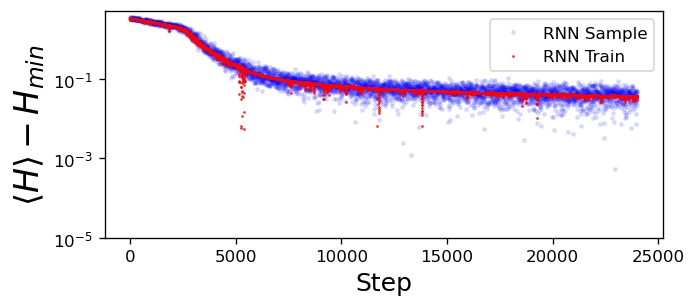

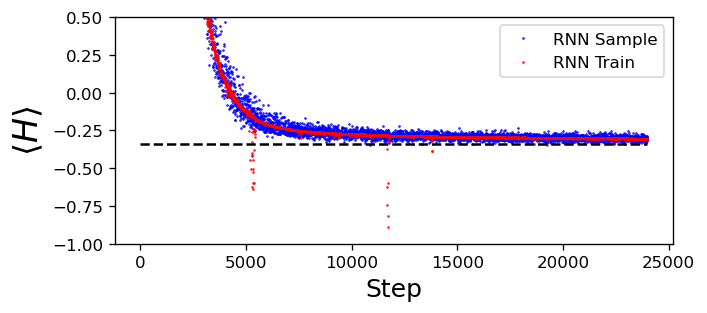

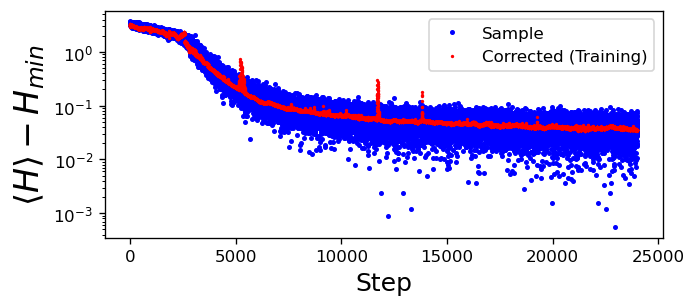

In [17]:
#show(32,32,0.99,mydir="out/stable")

# 4x4 Queue

In [20]:
run(4,0.99)

512 2 256 16


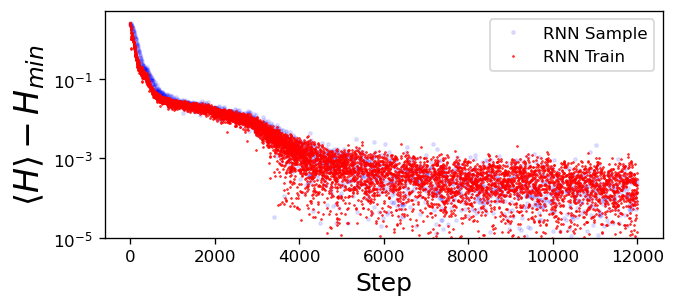

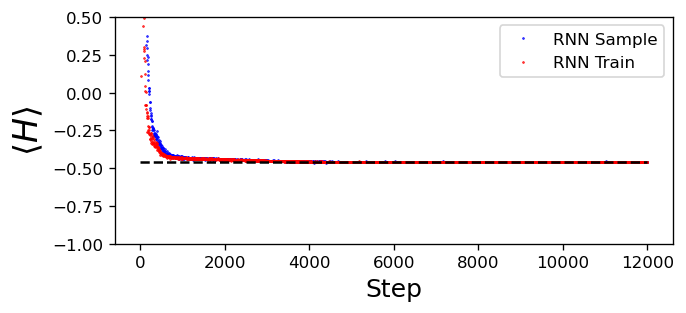

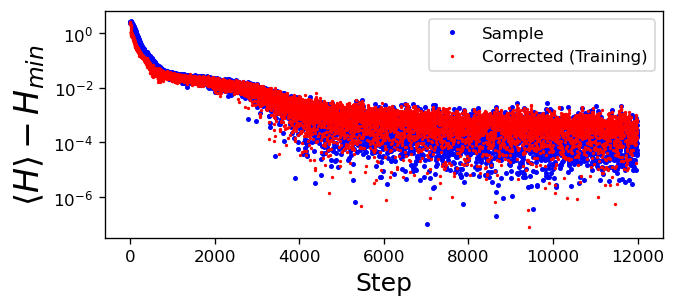

TIME: 137s
Last Corrected -0.4578


In [47]:
show(4,4,0.99)

# 6x6 Queue


In [36]:
run(6,0.99)

512 4 128 36


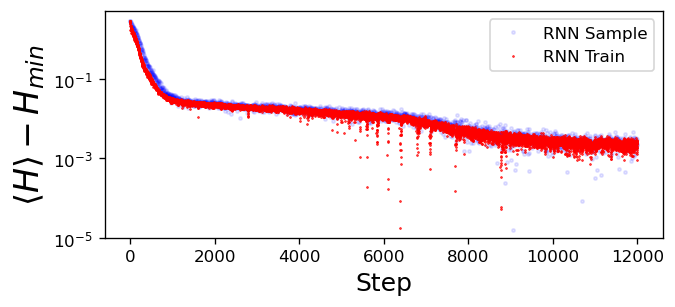

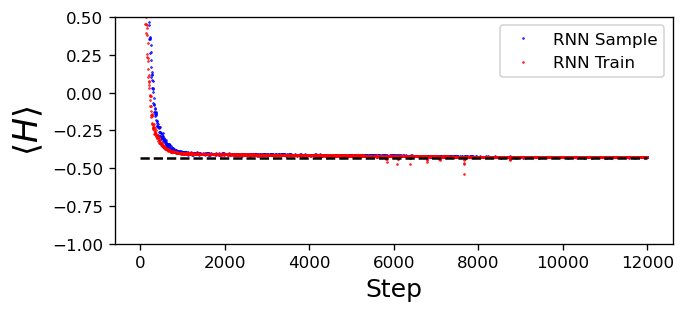

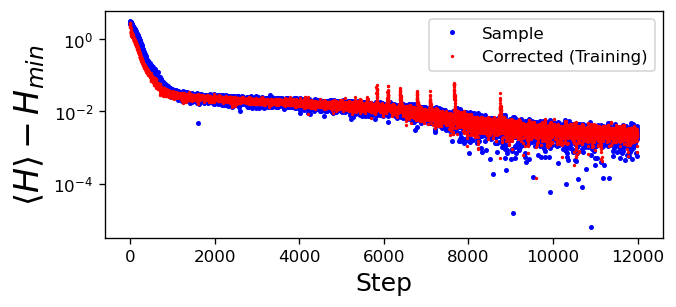

TIME: 260s
Last Corrected -0.4289


In [48]:
show(6,6,0.99)

# 8x8 Queue


In [49]:
run(8,0.99)

512 8 64 64


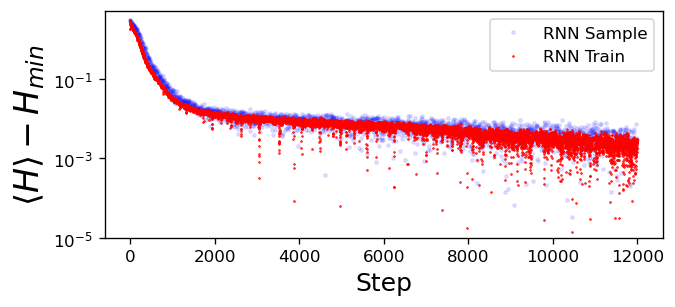

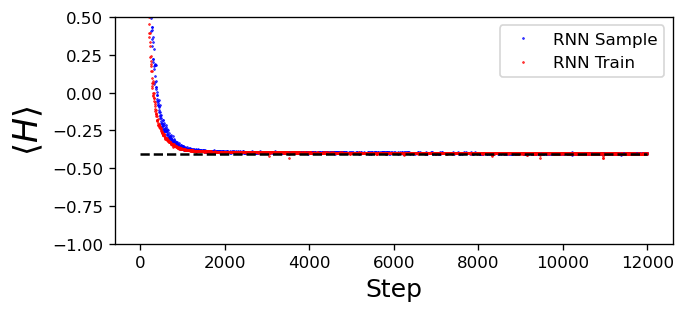

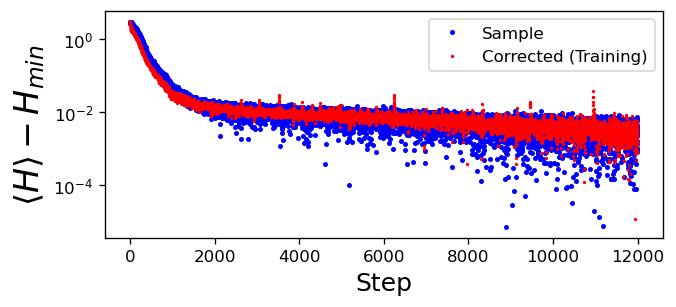

TIME: 427s
Last Corrected -0.4004


In [50]:
show(8,8,0.99)

# 12x12 Queue


In [51]:
run(12,0.99)

504 18 28 144


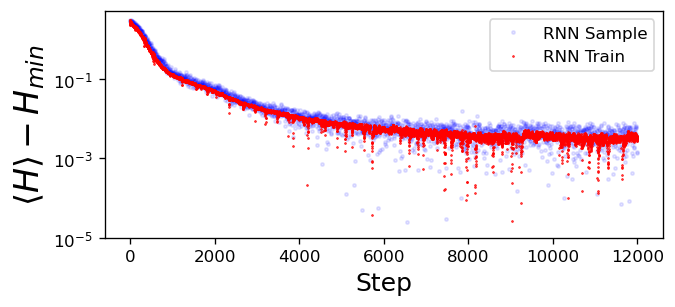

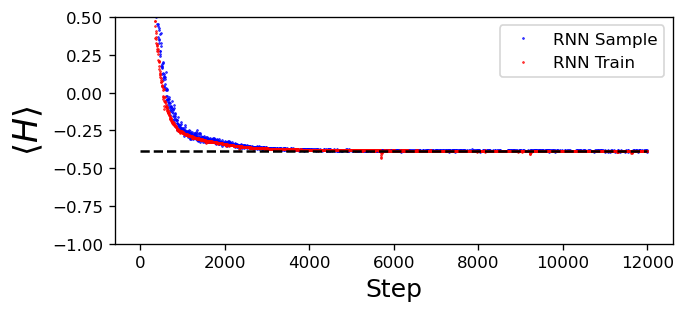

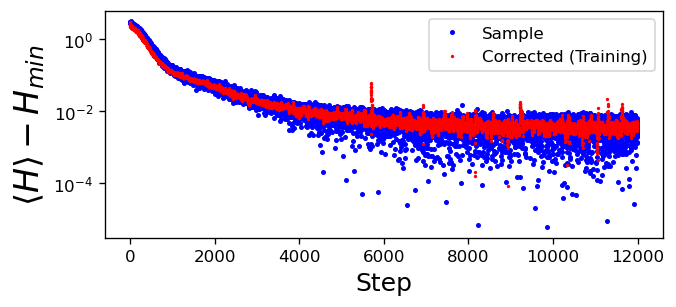

TIME: 902s
Last Corrected -0.3857


In [52]:
show(12,12,0.99)

# 16x16 Queue


In [53]:
run(16,0.99)

512 32 16 256


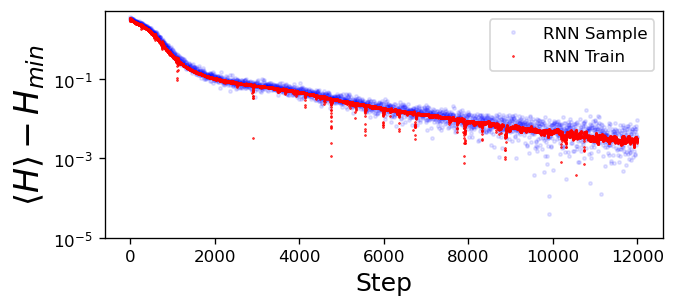

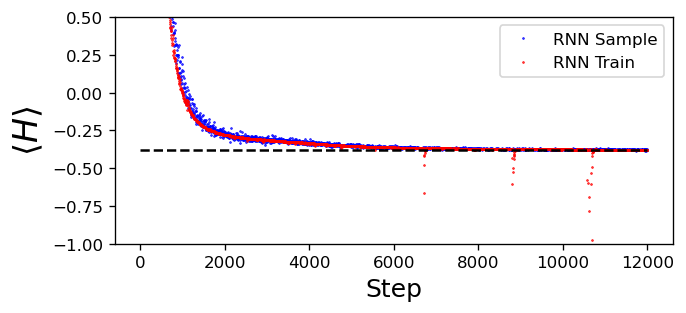

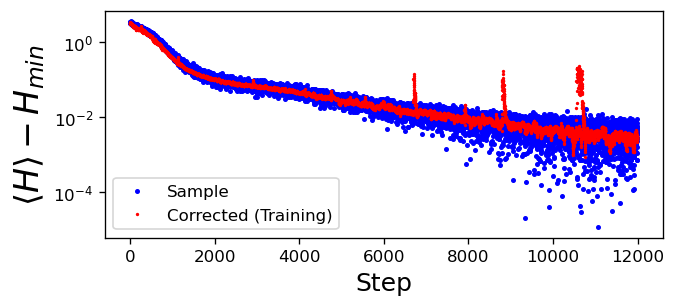

TIME: 1581s
Last Corrected -0.3774


In [54]:
show(16,16,0.99)

# No momentum:

512 2 256 16


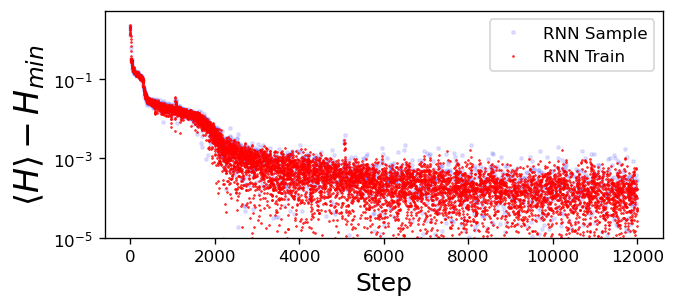

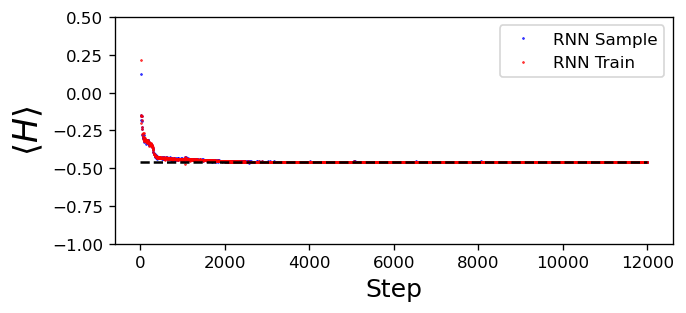

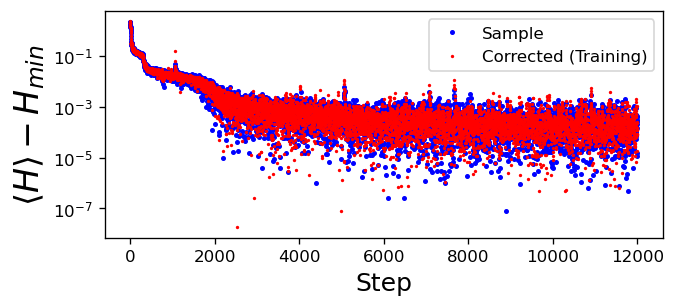

TIME: 137s
Last Corrected -0.4579
512 4 128 36


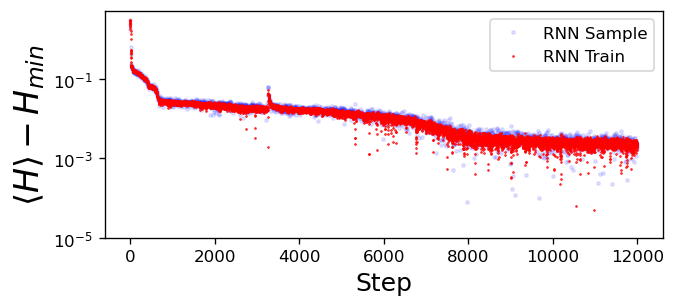

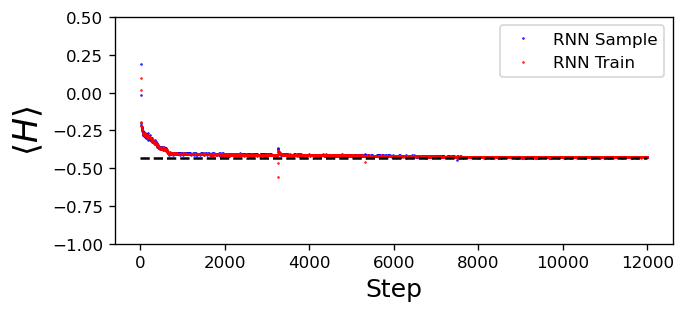

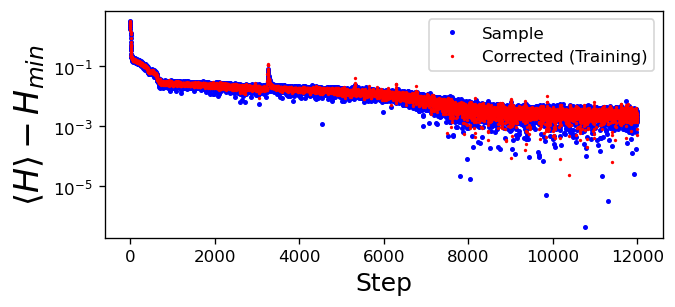

TIME: 263s
Last Corrected -0.4280
512 8 64 64


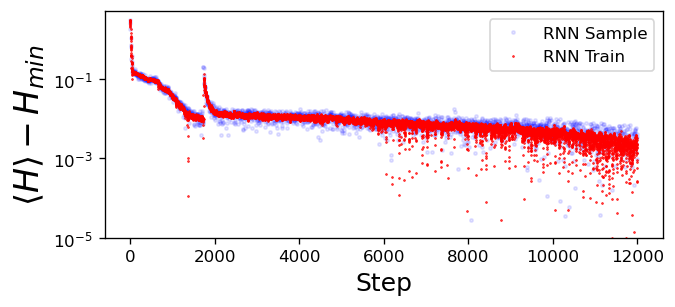

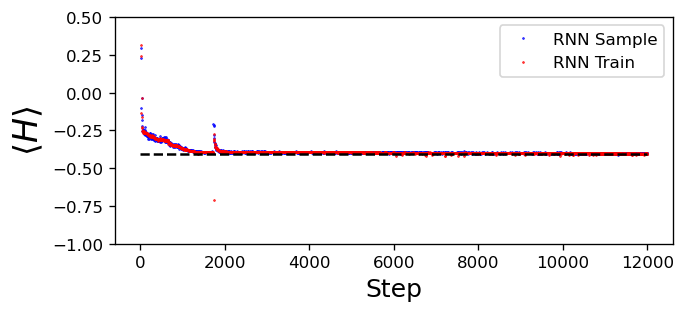

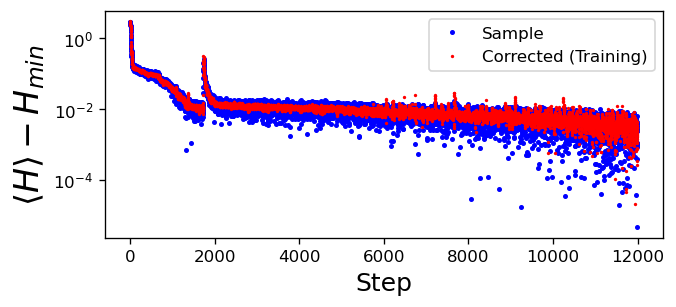

TIME: 426s
Last Corrected -0.4010
504 18 28 144


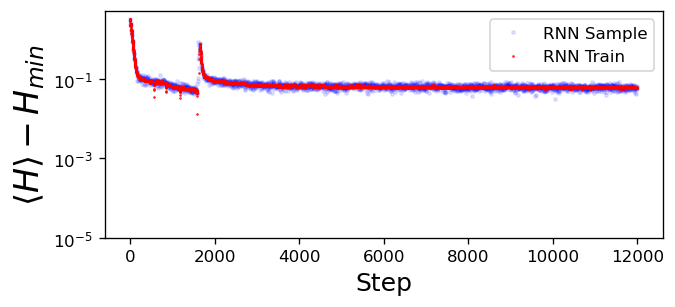

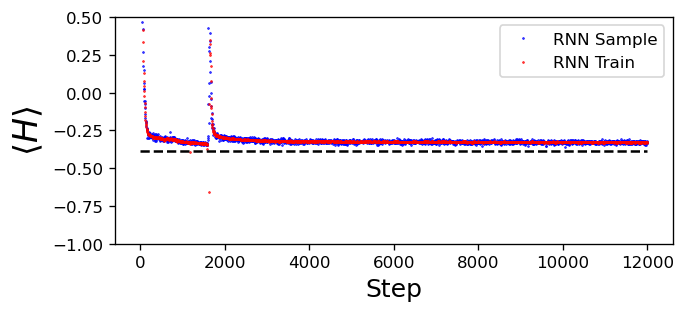

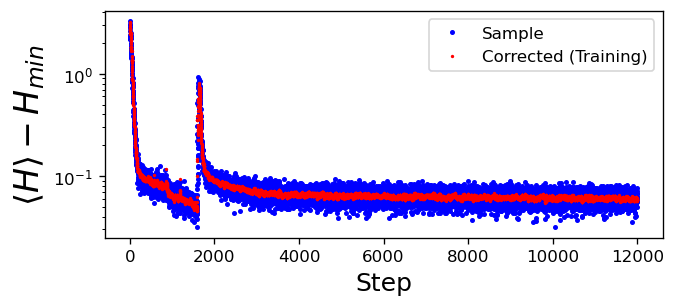

TIME: 896s
Last Corrected -0.3289
512 32 16 256


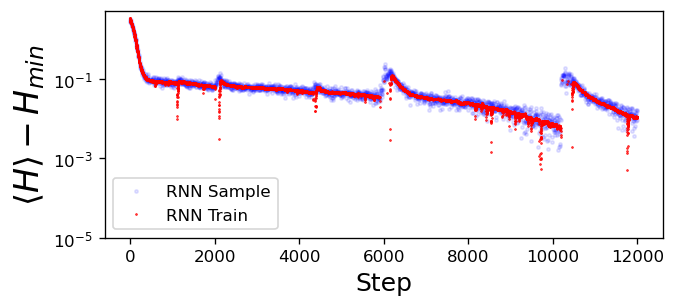

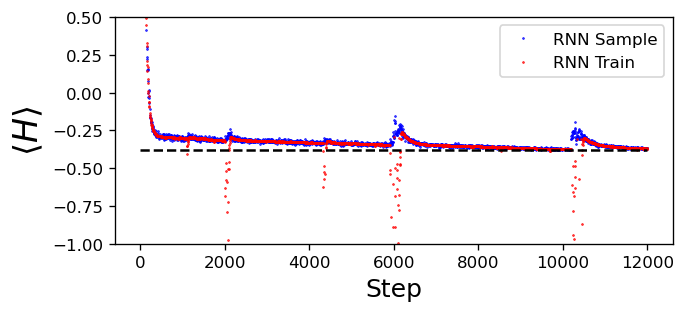

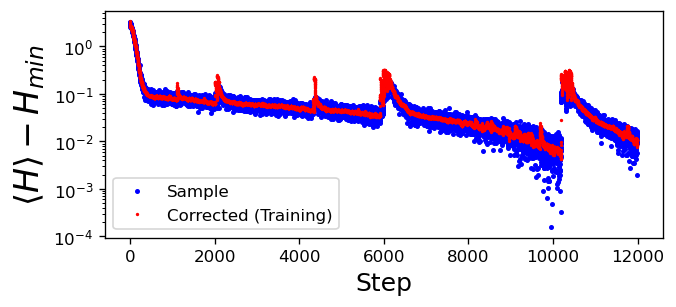

TIME: 1586s
Last Corrected -0.3697


In [56]:
run(4,0.0)
run(6,0.0)
run(8,0.0)
run(12,0.0)
run(16,0.0)
show(4,4,0.0)
show(6,6,0.0)
show(8,8,0.0)
show(12,12,0.0)
show(16,16,0.0)

# No Queue



512 2 256 16


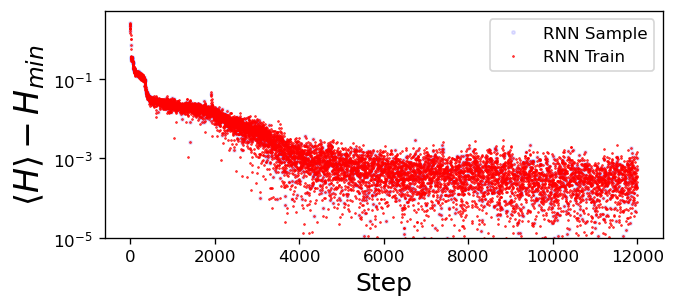

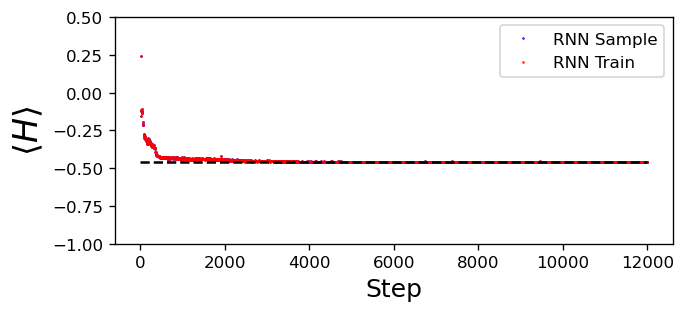

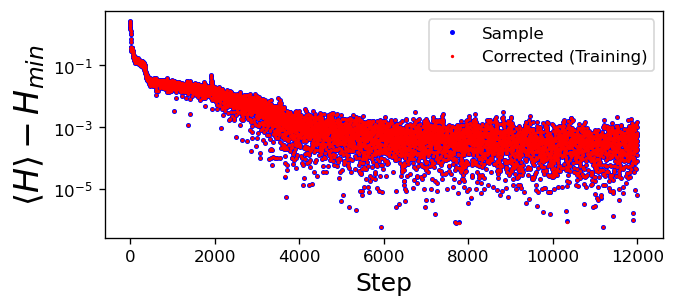

TIME: 135s
Last Corrected -0.4576
512 4 128 36


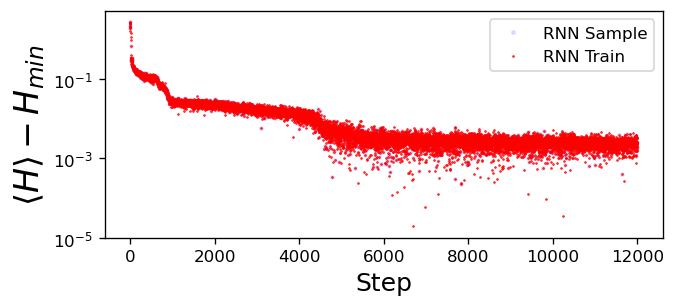

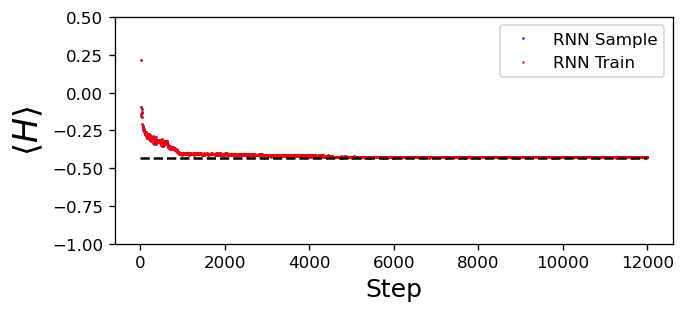

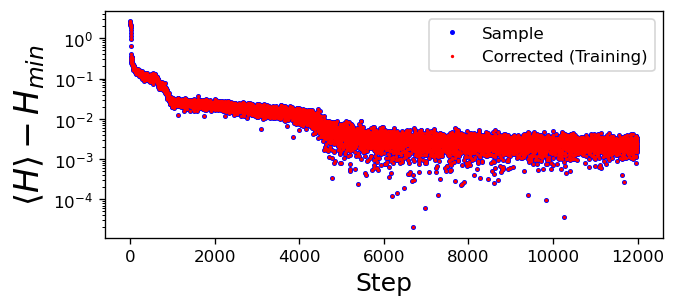

TIME: 262s
Last Corrected -0.4282
512 8 64 64


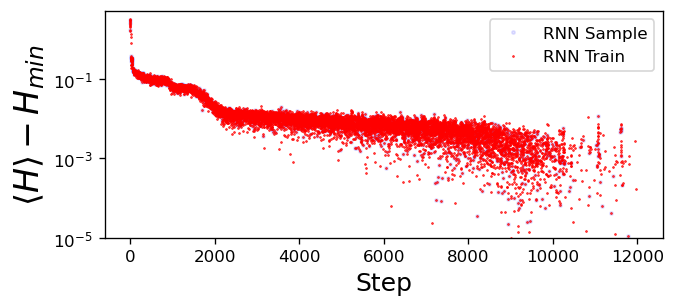

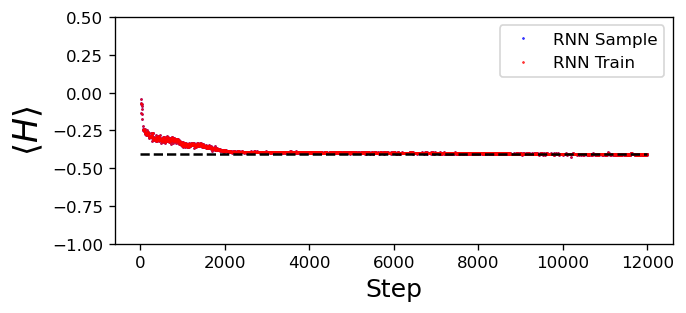

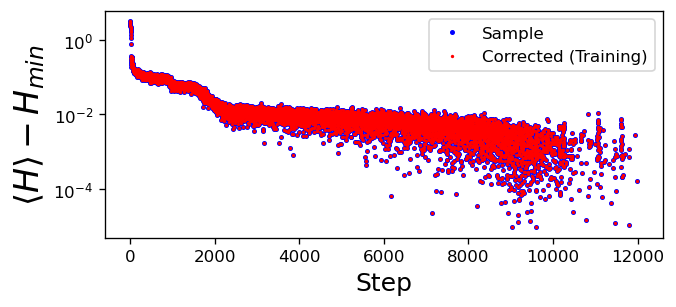

TIME: 428s
Last Corrected -0.4079
504 18 28 144


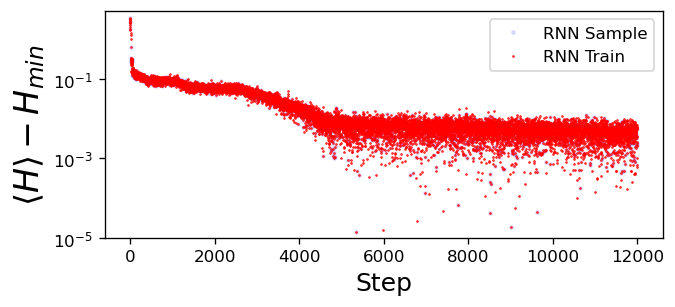

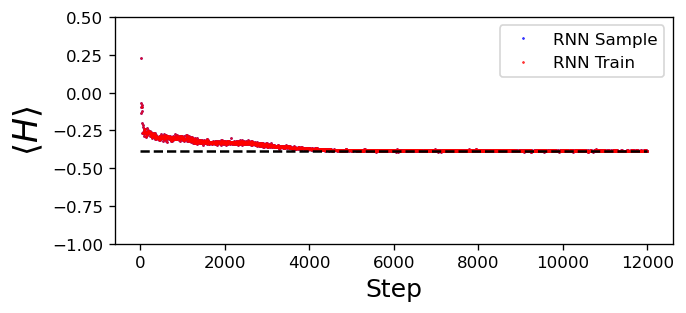

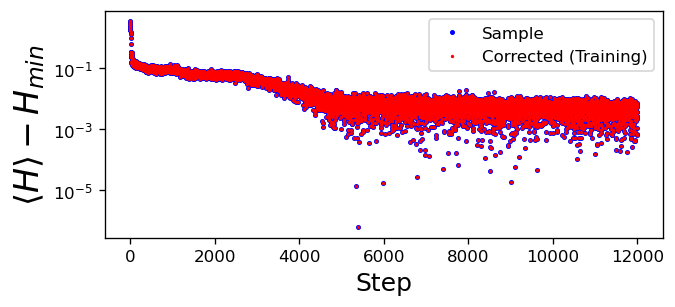

TIME: 862s
Last Corrected -0.3828
512 32 16 256


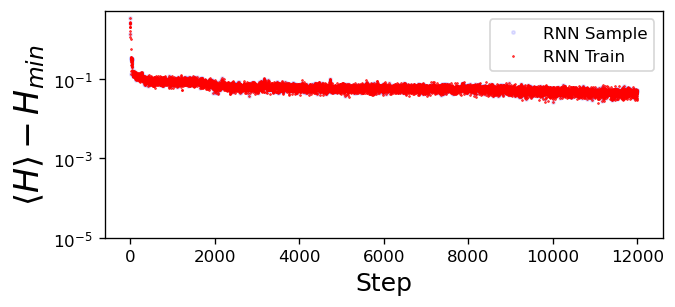

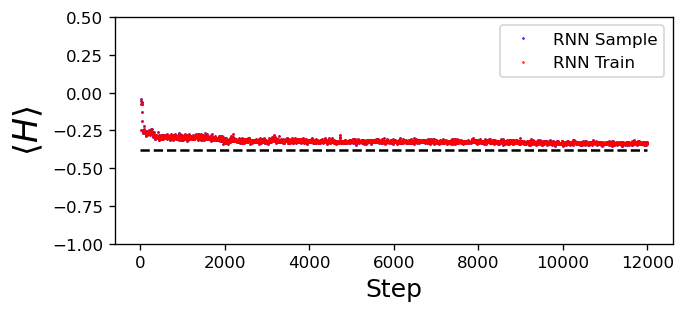

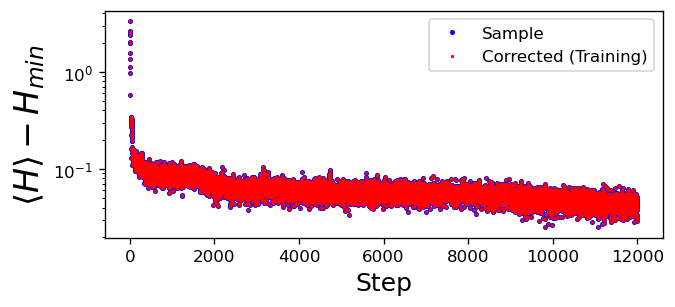

TIME: 1498s
Last Corrected -0.3298


In [57]:
run(4,0.0,noqueue=True)
run(6,0.0,noqueue=True)
run(8,0.0,noqueue=True)
run(12,0.0,noqueue=True)
run(16,0.0,noqueue=True)
show(4,4,0.0,noqueue=True)
show(6,6,0.0,noqueue=True)
show(8,8,0.0,noqueue=True)
show(12,12,0.0,noqueue=True)
show(16,16,0.0,noqueue=True)